# Visual-based road detection

* [Work Description](files/intro-docs/VCOM_2015-2016_Trabalho_1_v02.pdf)

This project focus on finding and extracting delimiter features (edges) present on a road. This ability is of great importance in computer vision field, namely in autonomous driver applications.

In this report, the evolution of the algorithm is shown throughout the iteration over images that, intuitively, represent increment of complexity in each image iteration.

The selection of images for testing is done with the criteria of representing the driver's point of view over the road (in order to simulate the image capturing in an autonomous vehicle).

### Tasks implemented
 * Detection of vanishing point (also in unstructured roads)
 * Road segmentation (also in unstructured roads)
 * Vehicle Detection

### Needed libraries

In [1]:
import cv2

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from operator import itemgetter
import sys

import numpy as np

# Determining the Vanishing Point

In order to accomplish the first task, it is needed to detect the lines that delimit the road, in order to find their intersection. That intersection represents the vanishing point.

We start of with a simple image.

In [2]:
def get_img(path, size=(600, 400), show=True):
    """ Function that fetches an image from a given path, and rescales it"""
    
    img = cv2.imread(path)
    img = cv2.resize(img, (600, 400))
    
    if show:
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis('off'); plt.title("Image"); plt.imshow(img_show, cmap='gray')
    
    return img

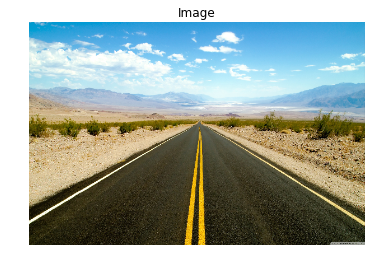

In [3]:
img_simple = get_img("pics/simple.jpg")

### Canny Algorithm

By applying the Canny algorithm, we obtain a single-channel binary image with the edges highlighted. This can be piped to Hough lines detector.

In [4]:
def apply_canny(img, lowThreshold, ratio=3, show=True):
    """ Function that applyes Canny algorithm in the img, with the provided parameters"""
    
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_edges = cv2.Canny(img_hls[:, :, 1], lowThreshold, lowThreshold * ratio, L2gradient=True)
    
    if show:
        plt.axis('off'); plt.title("Canny Filter"); plt.imshow(img_edges, cmap='gray')
        
    return img_edges

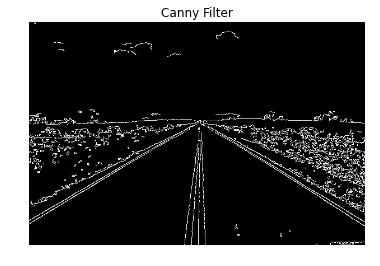

In [5]:
img_simple_edges = apply_canny(img_simple, 150, 2)

### Hough Lines Detector

As said previously, Hough lines detector should now be able to identify the road's boundary edges.

The following function obtains the edges using HoughLines function from OpenCV, and selects the two most important. As we started with the assumption that our images represent the driver's viewing angle, we can use the heuristic of selecting those lines according to their angle. With this information, it computes the line's intersection, and draws in in the output image

In [6]:
def apply_houghlines(img, edges, rho, threshold, show=True):
    """ Function that computes the two relevant edges of a road, and determines the vanishing with them """
    
    lines = cv2.HoughLines(edges, rho, np.pi/180.0, threshold)
    
    if lines is None or len(lines) < 2:
        print("Not enough valid lines detected")
        return
    
    img_edited = img.copy()

    # extract the most important lines
    lines = sorted(lines[:, 0, :], key=itemgetter(1))
    left_line = None
    right_line = None
    
    for rho, theta in lines:
        if theta > 0.0 and theta < np.pi/3.0:
            if right_line == None:
                right_line = (rho, theta)
        elif theta < 5*np.pi/6.0 and theta > np.pi/2.0:
            left_line = (rho, theta)
    
    if left_line == None or right_line == None:
        print("Not enough valid lines detected")
        return
            
    
    m_l = (- np.cos(left_line[1]) / np.sin(left_line[1]))
    m_r = (- np.cos(right_line[1]) / np.sin(right_line[1]))
    b_l = left_line[0] / np.sin(left_line[1])
    b_r = right_line[0] / np.sin(right_line[1])

    vp_x = (b_l - b_r) / (m_r - m_l)
    vp_y = m_l * vp_x + b_l

    # draw the vanishing point
    _ = cv2.circle(img_edited, (vp_x, vp_y), 10, (0, 0, 255), -2)
    _ = cv2.circle(img_edited, (vp_x, vp_y), 8, (255, 255, 255), -2)
    
    # draw the lines
    for rho, theta in [left_line, right_line]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
    
        if theta > np.pi / 2:
            x1 = vp_x
            y1 = vp_y
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
        else:
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = vp_x
            y2 = vp_y
        
        cv2.line(img_edited, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    if show:
        img_edited_show = cv2.cvtColor(img_edited, cv2.COLOR_BGR2RGB)
        plt.axis('off'); plt.title('W/ Vanishing Point'); plt.imshow(img_edited_show)
    
    return img_edited

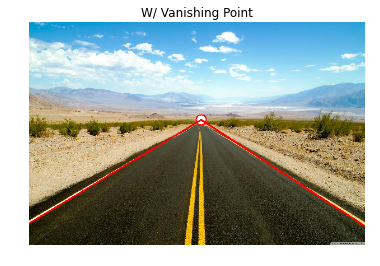

In [7]:
img_simple_vp = apply_houghlines(img_simple, img_simple_edges, 1, 150)

Of course this is an (almost) perfect example, where this simple process works very well.
The same process applyed to intuitively more difficult images is presented below:

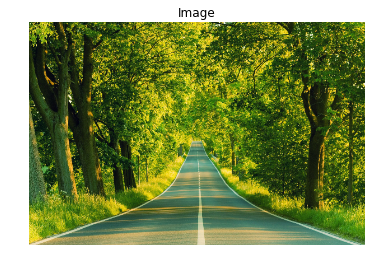

In [8]:
img_test1 = get_img('pics/trees.jpeg')

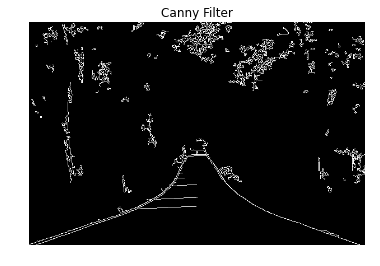

In [9]:
img_test1_edges = apply_canny(img_test1, 100, 5)

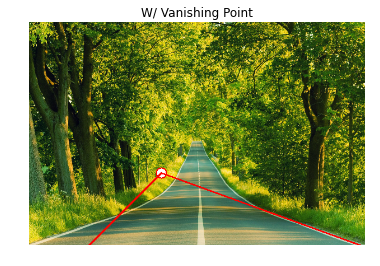

In [10]:
img_test1_vp = apply_houghlines(img_test1, img_test1_edges, 1, 74)

It's very difficult to extract the boundary defining lines from these images, as the boundary is not completely straight.
Gaussian blur applyed over the output of the Canny algorithm makes the edges wider, therefore it is easier to detect a straight line on them.

In [11]:
def apply_gaussian(img, show=True, single_channel=False):
    """ Applies Gaussian Blur over an image """
    
    img_blur = cv2.GaussianBlur(img, (15, 15), 0)
    img_blur = cv2.bilateralFilter(img_blur, 9, 75, 75)
    
    if show:
        if single_channel:
            plt.axis('off'); plt.title('Gaussian Blur'); plt.imshow(img_blur, cmap='gray')
        else:
            img_blur_show = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)
            plt.axis('off'); plt.title('Gaussian Blur'); plt.imshow(img_blur_show)
    
    return img_blur

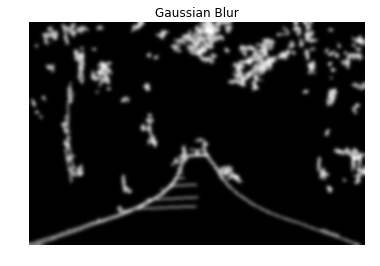

In [12]:
img_test1_edges_blur = apply_gaussian(img_test1_edges, single_channel=True)

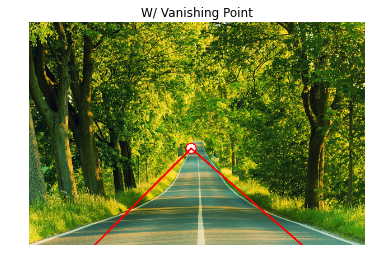

In [13]:
img_test1_edges_blur_vp = apply_houghlines(img_test1, img_test1_edges_blur, 1, 390)

Next, the current method is applyed to more unstructured examples.

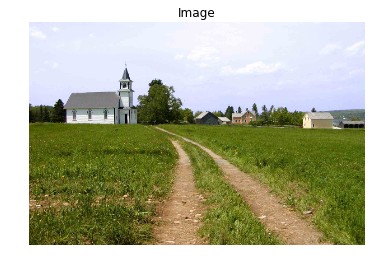

In [14]:
img_test2 = get_img('pics/middle-of-nowhere.jpeg')

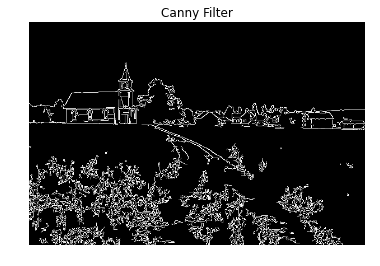

In [15]:
img_test2_edges = apply_canny(img_test2, 70, 5)

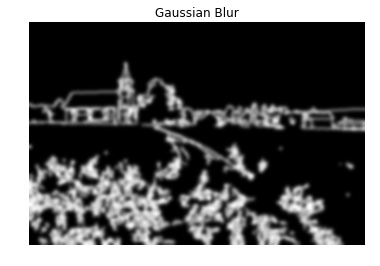

In [16]:
img_test2_edges_blur = apply_gaussian(img_test2_edges, single_channel=True)

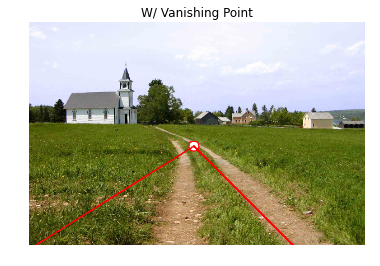

In [17]:
img_test2_edges_blur_vp = apply_houghlines(img_test2, img_test2_edges_blur, 1.2, 530)

The results are definitely not optimal. Thas has to do with the amount of noise detected in edge detection step.
Up next the method is tested with another unstructured example, to see if the results replicate.

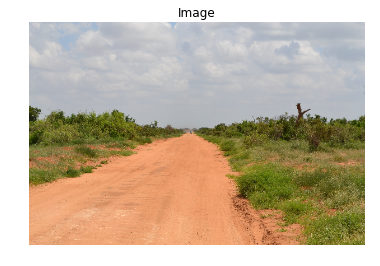

In [18]:
img_test3 = get_img('pics/difficult-dirt2.jpg')

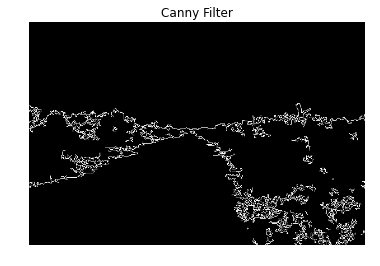

In [19]:
img_test3_edges = apply_canny(img_test3, 80, 4)

As seen, in unstructured road, even tweaking the parameters there is still a lot of noise found by Canny algorithm. Applying a bilateral filtering over the initial image may reduce it, as it blurs the image while preserving the edges.

In [20]:
def apply_bilateral(img, show=True, single_channel=False):
    img_blur = cv2.bilateralFilter(img, 15, 160, 160)
    
    if show:
        if single_channel:
            plt.axis('off'); plt.title('Bilateral Filtering'); plt.imshow(img_blur, cmap='gray')
        else:
            img_blur_show = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)
            plt.axis('off'); plt.title('Bilateral Filtering'); plt.imshow(img_blur_show)
    
    return img_blur

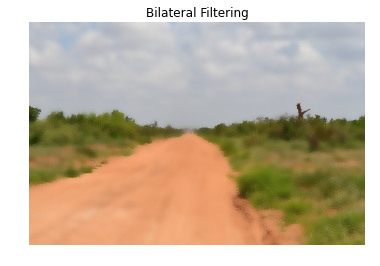

In [21]:
img_test3_bf = apply_bilateral(img_test3)

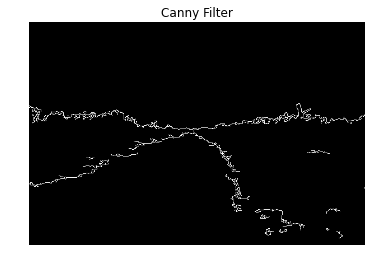

In [22]:
img_test3_edges = apply_canny(img_test3_bf, 40, 3)

A lot less of noise is found. But as seen the road edges are still very noisy. The previously used gaussian blur may make it easier to detect the edges even so.

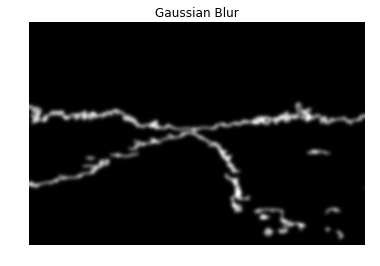

In [23]:
img_test3_edges_blur = apply_gaussian(img_test3_edges, single_channel=True)

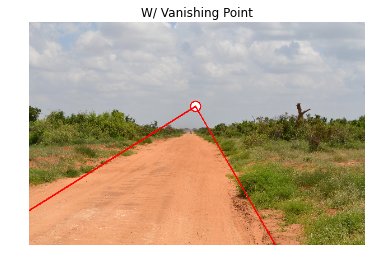

In [24]:
img_test3_edges_blur_vp = apply_houghlines(img_test3, img_test3_edges_blur, 1, 200)

These results are very good, given how noisy and unstructured the road's boundaries are.

Then, our final algorithm involves the following iterative steps:
 * Resize the image (600x400), to standardize the method;
 * Apply a Bilateral Filtering over it, to reduce the noise both inside the road and outside of it, while preserving the edges;
 * Apply Canny Algorithm to detect the edges in the image;
 * Apply Gaussian Blur over the previous output image, to reduce the boundary noise, therefore make the lines easier to detect;
 * Apply Hough Lines Detector Algorithm, from where two main edges are selected (based on their angle), and use them to find the vanishing point.

# Road Segmentation

We'll start off with the simple example

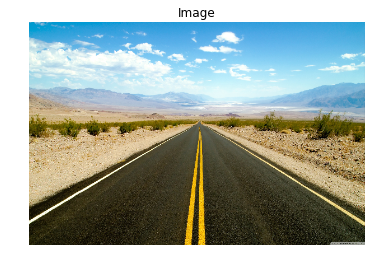

In [25]:
img_simple = get_img("pics/simple.jpg")

We performed tests with the following algorithms:
 * __Histogram Backprojection__ which outputs a very noisy mask;
 * __Watersheding__ which makes it very difficult to merge *a posteriory* the resulting regions, while not being sensitive to individual colors intensity
 * __K-Means__ which, if we select two clusters, misidentifies the regions, and if we select more, suffers from the merging the resulting regions problem
 

Allongside these reasons, the algorithms presented did not enable us to abstract over if the road is lighter or darker than its boundaries.

In the end, we decided to use Graph Cut algorithm, as it enables us to take advantage of the relatively predictable structure of the image, in the way presented in the following table:
 

|                     |    Picture Scene    |                     | 
|:-------------------:|:-------------------:|:-------------------:|
|      Background     | Probably Background |      Background     |
| Probably Background | Probably Foreground | Probably Background |
| Probably Foreground |      Foreground     | Probably Foreground |

In [26]:
def apply_graphcut(img, show=True):
    """ Applies the graph cut algorithm to segment the image, based on a 9x9 grid mask """
    
    mask = np.zeros(img.shape[:2],np.uint8)
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
   
    rect = (1,150,599,400)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    
    
    # cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD
    mask = np.ones(img.shape[:2], dtype='uint8')
    mask[0:100, 0:200] = cv2.GC_BGD
    mask[0:100, 200:400] = cv2.GC_PR_BGD
    mask[0:100, 400:600] = cv2.GC_BGD
    
    mask[100:300, 0:200] = cv2.GC_PR_BGD
    mask[100:300, 200:400] = cv2.GC_PR_FGD
    mask[100:300, 400:600] = cv2.GC_PR_BGD
    
    mask[100:200, 0:100] = cv2.GC_BGD
    mask[100:200, 500:600] = cv2.GC_BGD
    
    mask[300:400, 0:200] = cv2.GC_PR_FGD
    mask[300:400, 200:400] = cv2.GC_FGD
    mask[300:400, 400:600] = cv2.GC_PR_FGD 
    
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask[:,:,np.newaxis]
    
    
    if show:
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis('off'); plt.title("Graph Cut"); plt.imshow(img_show)
    
    return img

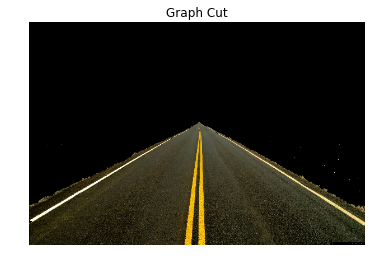

In [27]:
img_simple_segm = apply_graphcut(img_simple)

The results using Graph Cut are very good in this example. Next it is applied to other examples:

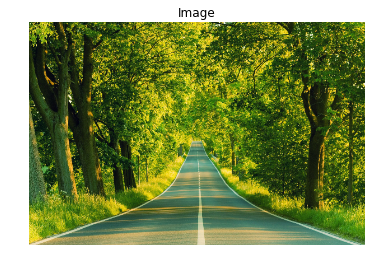

In [28]:
img_test1 = get_img("pics/trees.jpeg")

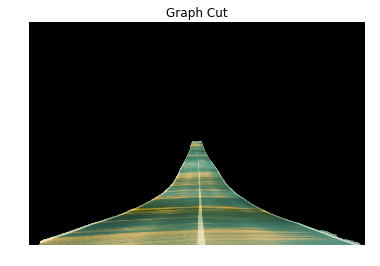

In [29]:
_ = apply_graphcut(img_test1)

It also works really well with roads whose boundaries are not straight.

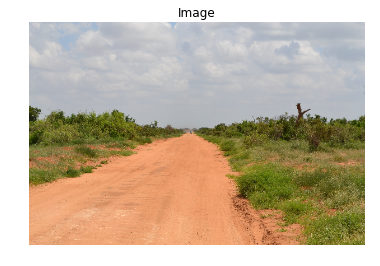

In [30]:
img_test2 = get_img("pics/difficult-dirt2.jpg")

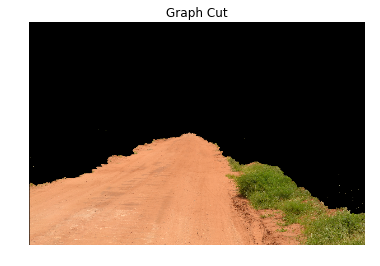

In [31]:
_ = apply_graphcut(img_test2)

In unstructured roads the results are also very reasonable.

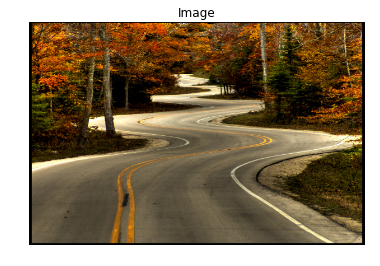

In [32]:
img_test3 = get_img("pics/curvy3.jpg")

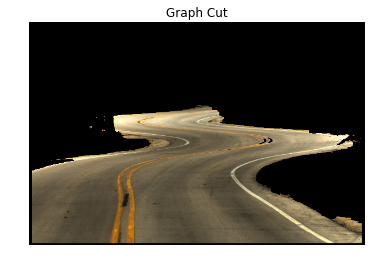

In [33]:
_ = apply_graphcut(img_test3)

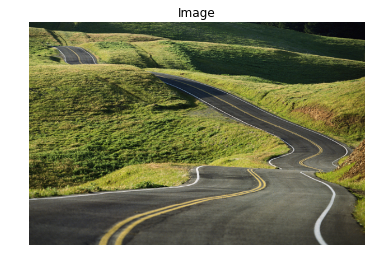

In [34]:
img_test4 = get_img("pics/curvy4.jpg")

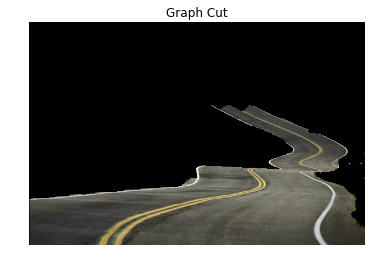

In [35]:
_ = apply_graphcut(img_test4)

We see here a very good performance even on roads with many turns.

# Vehicle Detection

Next, we will implement a methodology that uses an already trained model to identify vehicles.
The model detects relevant features from the image, like edges and corners, and based on the previous training, identifies rectangles in the image that are similar to the cars in the training dataset.

In [36]:
img_car = get_img("pics/test-1.pgm", size=(210,115))

In [37]:
def apply_clahe(img, show=True):
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
    img_hls[:, :, 1] = clahe.apply(img_hls[:, :, 1])
    
    if show:
        img_show = cv2.cvtColor(img_hls, cv2.COLOR_HLS2RGB)
        plt.axis('off'); plt.title('CLAHE'); plt.imshow(img_show)
    
    return cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)

In [38]:
def detect_cars(img, min_neighbors, show=True):
    
    img_clahe = apply_clahe(img, show=False)
    img_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    img_cp = img.copy()
    
    main_cascade = cv2.CascadeClassifier()
    main_cascade.load('cascade/cas1.xml')
    #main_cascade.load('cascade/cas2.xml')
    main_cascade.load('cascade/cas3.xml')
    main_cascade.load('cascade/cas4.xml')
    test_cascade = cv2.CascadeClassifier('cascade/checkcas.xml')
    
    cars = main_cascade.detectMultiScale(img_gray, 1.2, min_neighbors, 0, (10, 10))
    
    for (x,y,w,h) in cars:
        cv2.rectangle(img_cp, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    if show:
        img_show = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)
        plt.axis('off'); plt.title("Cars Detection"); plt.imshow(img_show)
    
    return img_cp

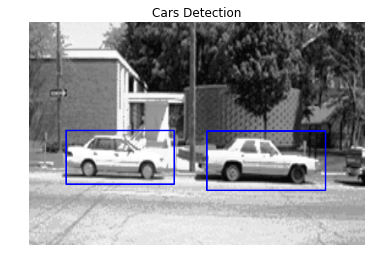

In [39]:
_ = detect_cars(img_car, 18)

As shown, procedure enables us to detect cars that are driving transversely to us.
Now, we'll try to detect the rear part of the vehicles.

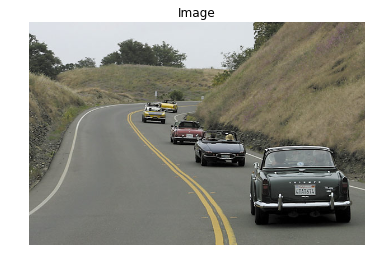

In [40]:
img_test1 = get_img("pics/with-cars.jpg", size=(210,115))

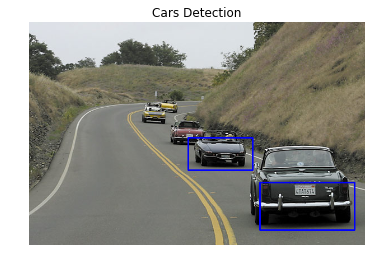

In [41]:
_ = detect_cars(img_test1, 38)

It is able to correctly identify two of the nearest vehicles in the image by their rear.

# Conclusions

With this project the team developed ability to perform complex computer vision techniques associated with the tasks performed by autonomous vehicles, as well as sensitivity to computer vision concepts and their implications in a algorithms pipeline.